In [6]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
np.random.seed(1337)

In [7]:
train_folder = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Train\1/"
val_file = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Validation\n10degC_LA92_Pan18650PF.mat"
test_file = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Test\Test.mat"
minmax_file = r"D:\test_development\Battery\data2\Panasonic 18650PF Data prepared\Panasonic_NCR18650PF_Data_Normalized\Normalization\MIN_MAX_Normalization.mat"
cols = ['V', 'I', 'T']

In [8]:
def butter(x):
    hz = 1
    b, a = scipy.signal.butter(1, 0.0005/(hz/2))
    x['V0.5m'] = scipy.signal.filtfilt(b, a, x['V'])
    x['I0.5m'] = scipy.signal.filtfilt(b, a, x['I'])
    b, a = scipy.signal.butter(1, 0.005/(hz/2))
    x['V5m'] = scipy.signal.filtfilt(b, a, x['V'])
    x['I5m'] = scipy.signal.filtfilt(b, a, x['I'])
    x.drop(columns=['V', 'I'], inplace=True)

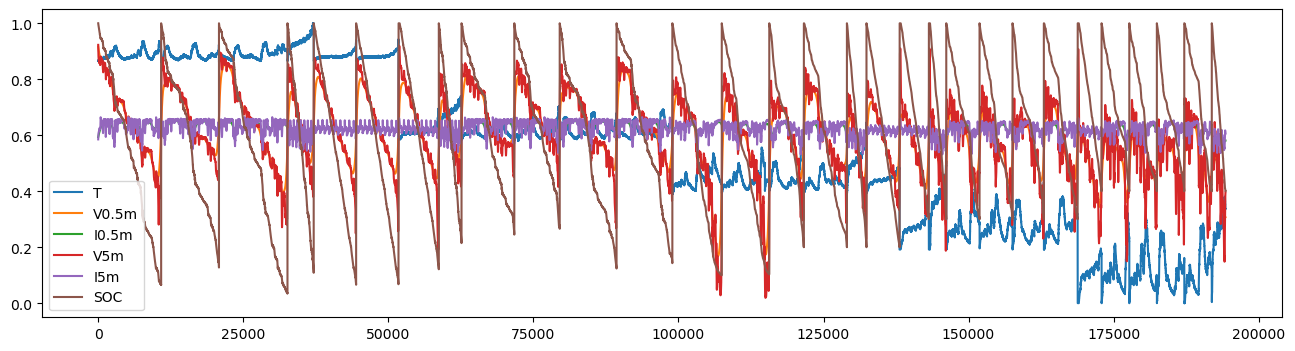

In [5]:
x_train = pd.DataFrame()
y_train = pd.DataFrame()
for file in os.listdir(train_folder):
    mat = scipy.io.loadmat(train_folder + file)
    x_train = pd.concat([x_train, pd.DataFrame(mat['X']).T[[0, 1, 2]]], ignore_index=True)
    y_train = pd.concat([y_train, pd.DataFrame(mat['Y']).T], ignore_index=True)
x_train.columns = cols
y_train.columns = ['SOC']
butter(x_train)
pd.concat([x_train, y_train], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

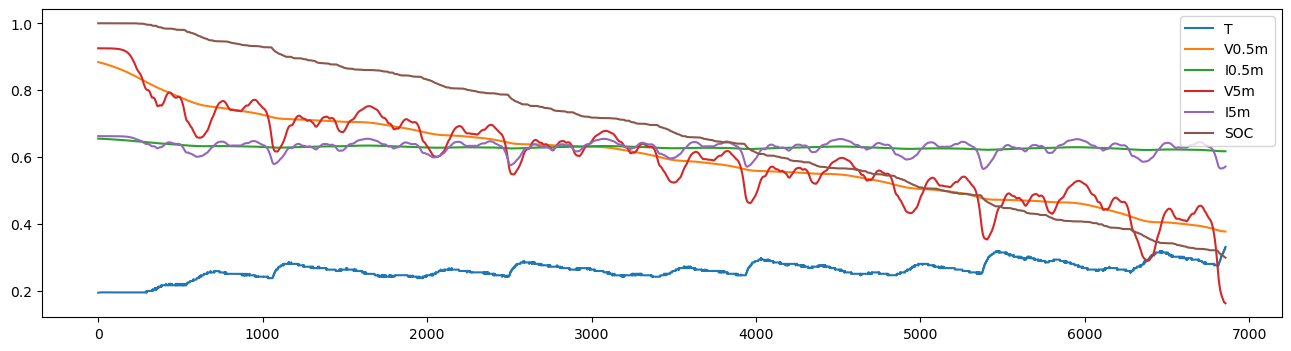

In [6]:
mat = scipy.io.loadmat(val_file)
x_val = pd.DataFrame(mat['X']).T[[0, 1, 2]]
y_val = pd.DataFrame(mat['Y']).T
x_val.columns = cols
y_val.columns = ['SOC']
butter(x_val)
pd.concat([x_val, y_val], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

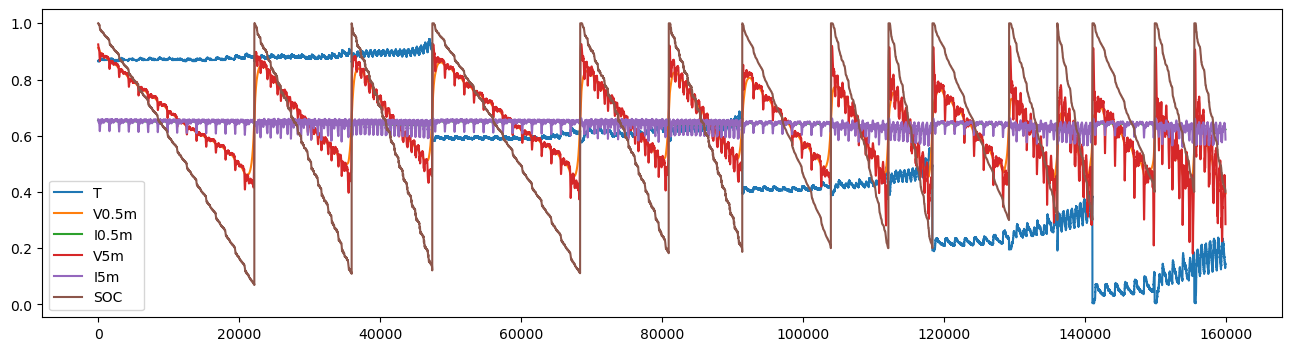

In [7]:
x_tests = {}
y_tests = {}
mat = scipy.io.loadmat(test_file)
for i in range(len(mat['X_Test'][0])):
    x_tests[mat['X_Test'][0][i][0]] = pd.DataFrame(mat['X_Test'][1][i]).T[[0, 1, 2]]
    y_tests[mat['Y_Test'][0][i][0]] = pd.DataFrame(mat['Y_Test'][1][i]).T

x_test = pd.concat([df for df in x_tests.values()], ignore_index=True)
y_test = pd.concat([df for df in y_tests.values()], ignore_index=True)
x_test.columns = cols
y_test.columns = ['SOC']
butter(x_test)
pd.concat([x_test, y_test], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

In [8]:
def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(21, activation='relu'),
  tf.keras.layers.Dense(19, activation='relu'),
  tf.keras.layers.Dense(1, activation=clipped_relu)
])

model.compile(optimizer='adam',
              loss='mean_squared_error')

history = model.fit(
  x_train.values,
  y_train.values,
  epochs=10,
  validation_data=(x_val, y_val),
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)]
)

Train on 194280 samples, validate on 6856 samples
Epoch 1/10
194280/194280 [==============================] - 7s 37us/sample - loss: 0.0039 - val_loss: 6.5439e-04
Epoch 2/10
194280/194280 [==============================] - 7s 34us/sample - loss: 0.0016 - val_loss: 8.3198e-04


In [9]:
def test_eva(x, y):
    model.evaluate(x, y)
    prediction = pd.DataFrame(model.predict(x), columns=['predicted SOC'])

    # Visualising the results
    pd.concat([prediction, y], axis=1).plot(figsize=(16, 4), legend=True)
    plt.show()


3600/3600 [==============================] - 0s 23us/sample - loss: 2.7566e-04


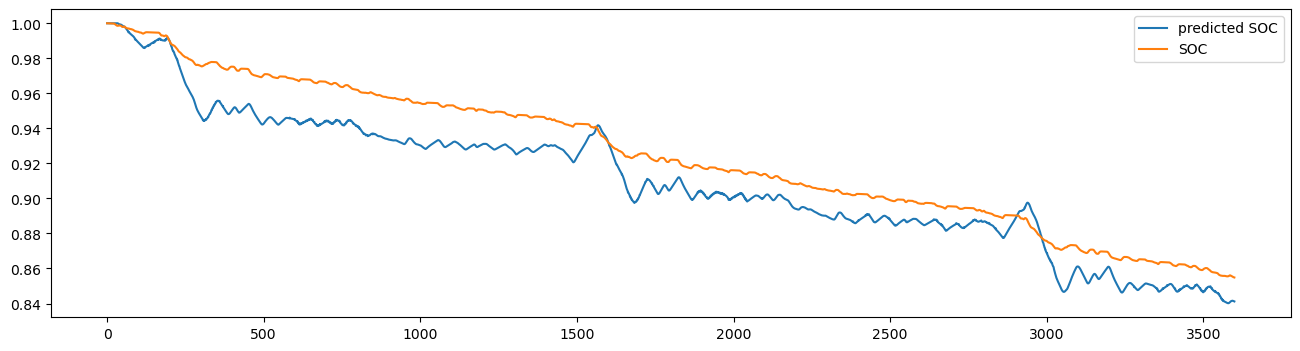

In [10]:
test_eva(x_test.head(3600), y_test.head(3600))

2940


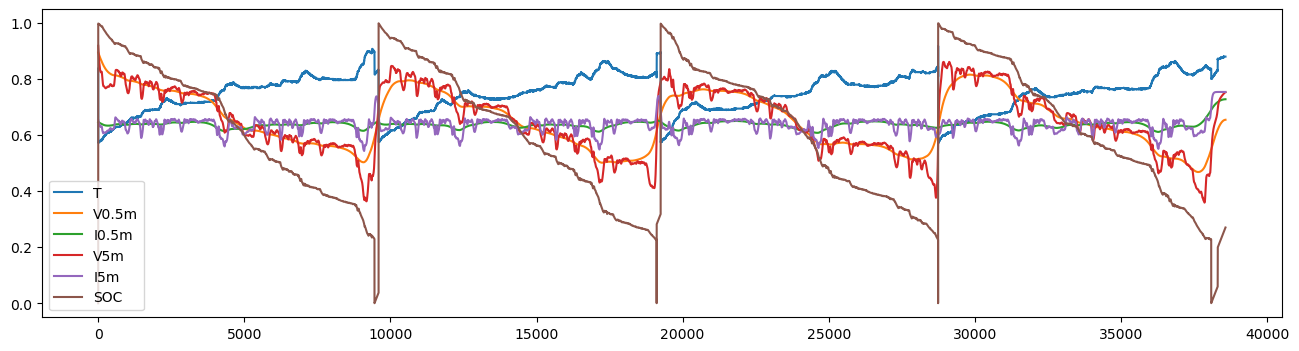

In [9]:
def from_mat(raw_file):
    mat = scipy.io.loadmat(raw_file)
    x = pd.DataFrame()
    for i, col in enumerate(mat['meas'][0][0]):
        x = pd.concat([x, pd.DataFrame(col, columns=[i])], axis=1)
    x.drop(columns=[4, 5, 7, 8], inplace=True)
    x[0] = x[0].str[0]
    x.loc[x[0].str.len() < 15, 0] = x[0] + ' 12:00:00 AM'
    x.index = pd.to_datetime(x[0], format='%m/%d/%Y %I:%M:%S %p')
    x = x.resample('S').mean()
    x.dropna(how='all', inplace=True)
    return x

def from_raw(df):
    x = df.copy()

    condition = (abs(x - x.shift()) <= 0.0005).any(axis=1)
    # condition = (x == x.shift()).any(axis=1)

    duplicates = x[condition].groupby((~condition).cumsum())
    print(len(duplicates))
    for name, df_type in list(duplicates):
        if len(df_type) > 300:
            x.drop(df_type.index, inplace=True)
    x = x.reset_index(drop=True)
    y = pd.DataFrame(x.pop(3))

    x.columns = cols
    y.columns = ['SOC']

    minmax = scipy.io.loadmat(minmax_file)
    x = (x - minmax['MIN'][0]) / (minmax['MAX'][0] - minmax['MIN'][0])

    y = y / 3 % 1

    butter(x)

    return x, y

df_new = from_mat(r"D:\test_development\Battery\data2\Panasonic 18650PF Data original\10degC Trise with pause\07-19-17_10.33 10degC_trise_Cycle_1to4_w_pauses_Pan18650PF.mat")
x_other, y_other = from_raw(df_new)

pd.concat([x_other, y_other], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

38577/38577 [==============================] - 1s 24us/sample - loss: 0.0040


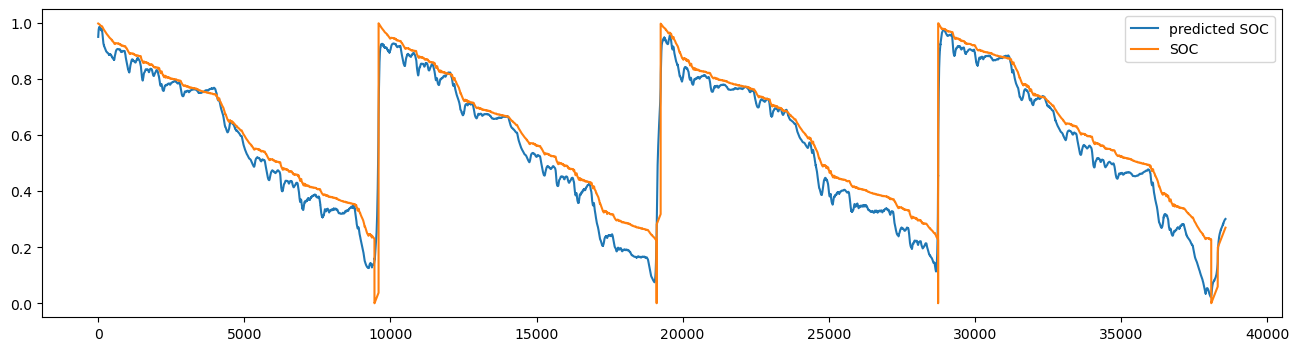

In [235]:
test_eva(x_other, y_other)

980


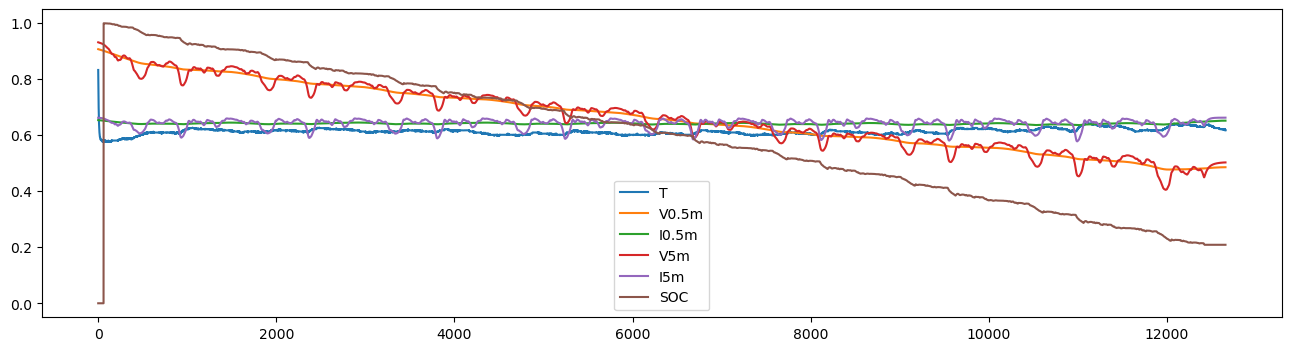

In [11]:
df_new = from_mat(r"D:\test_development\Battery\data2\Panasonic 18650PF Data original\10degC\Drive Cycles\03-27-17_09.06 10degC_LA92_Pan18650PF.mat")
x_other, y_other = from_raw(df_new)

pd.concat([x_other, y_other], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()